## Install Data and Flair

In [1]:
!git clone https://github.com/nlp-pucrs/fall-detection -q
!pip install flair -q

     |████████████████████████████████| 143kB 9.4MB/s 
     |████████████████████████████████| 133kB 52.5MB/s 
     |████████████████████████████████| 655kB 53.8MB/s 
     |████████████████████████████████| 798kB 52.4MB/s 
     |████████████████████████████████| 1.0MB 28.6MB/s 


## Load Data

In [2]:
import pandas as pd

quedas = pd.read_csv('fall-detection/training_data.csv')

quedas.shape, quedas.columns

((1078, 34), Index(['Unnamed: 0', 'Evolucao', 'Target',
        'Condições do paciente antes da queda',
        'Dano não classificado adequadamente', 'Dúvida para Janete',
        'Fator de Risco - Comportamental', 'Fator de Risco - Extrínseco',
        'Fator de Risco - Intrínseco',
        'Foi necessário algum procedimento. Qual?', 'Grau do Dano - Grave',
        'Grau do Dano - Leve', 'Grau do Dano - Moderado',
        'Grau do Dano - Nenhum', 'Grau do Dano - Óbito',
        'Necessitou de avaliação médica',
        'Orientações para prevenção ANTES da queda?',
        'Orientações para prevenção DEPOIS da queda?', 'Outro setor: Qual?',
        'Paciente acompanhado', 'Paciente não acompanhado',
        'Queda não classificada', 'Registro da MORSE',
        'Se foi na unidade de internação. Qual local?',
        'Tipo de Queda I - Acidental',
        'Tipo de Queda I - Fisiológica Antecipada',
        'Tipo de Queda I - Não Antecipada', 'Tipo de Queda II - Ao Solo',
        'Tipo 

## Load Flair Sentences

In [0]:
from flair.data import Sentence

sentences = []

for i in quedas.index:
  sentence = sentence = Sentence(quedas['Evolucao'][i], use_tokenizer=True)
  sentence.add_label('queda', str(quedas['Target'][i]))
  sentences.append(sentence)

## Load NILC Embeddgins

In [4]:
from flair.embeddings import NILCEmbeddings

nilc_embedding = NILCEmbeddings('fasttext')

2019-07-23 19:45:52,946 http://143.107.183.175:22980/download.php?file=embeddings/fasttext/skip_s100.zip not found in cache, downloading to /tmp/tmpcgnlyp61


100%|██████████| 313991848/313991848 [19:22<00:00, 270055.52B/s]

2019-07-23 20:05:16,096 copying /tmp/tmpcgnlyp61 to cache at /root/.flair/embeddings/fasttext/skip_s100.zip


2019-07-23 20:05:16,720 removing temp file /tmp/tmpcgnlyp61
2019-07-23 20:05:16,770 Reading embeddings from /root/.flair/embeddings/fasttext/skip_s100.zip


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Train the Model
based on https://github.com/zalandoresearch/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

In [5]:
from flair.data import Corpus
from flair.embeddings import DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

# 1. get the corpus
corpus = Corpus(sentences[:1000], sentences[1000:], sentences[1000:]) 

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [nilc_embedding]

# 4. initialize document embedding by passing list of word embeddings
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('fall-train/',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=150)

2019-07-23 20:06:53,537 {'1', '0'}
2019-07-23 20:07:00,368 ----------------------------------------------------------------------------------------------------
2019-07-23 20:07:00,369 Evaluation method: MICRO_F1_SCORE
2019-07-23 20:07:00,722 ----------------------------------------------------------------------------------------------------
2019-07-23 20:07:01,661 epoch 1 - iter 0/32 - loss 0.71004659
2019-07-23 20:07:02,625 epoch 1 - iter 3/32 - loss 0.67612775
2019-07-23 20:07:04,262 epoch 1 - iter 6/32 - loss 0.63835382
2019-07-23 20:07:05,054 epoch 1 - iter 9/32 - loss 0.64605298
2019-07-23 20:07:05,910 epoch 1 - iter 12/32 - loss 0.63523429
2019-07-23 20:07:06,692 epoch 1 - iter 15/32 - loss 0.64211859
2019-07-23 20:07:07,400 epoch 1 - iter 18/32 - loss 0.64011177
2019-07-23 20:07:08,790 epoch 1 - iter 21/32 - loss 0.63915680
2019-07-23 20:07:09,650 epoch 1 - iter 24/32 - loss 0.63274335
2019-07-23 20:07:10,544 epoch 1 - iter 27/32 - loss 0.63265841
2019-07-23 20:07:11,361 epoch 1

{'dev_loss_history': [tensor(0.6339, device='cuda:0'),
  tensor(0.6207, device='cuda:0'),
  tensor(0.6689, device='cuda:0'),
  tensor(0.5678, device='cuda:0'),
  tensor(0.6289, device='cuda:0'),
  tensor(0.5477, device='cuda:0'),
  tensor(0.7136, device='cuda:0'),
  tensor(0.5339, device='cuda:0'),
  tensor(0.5686, device='cuda:0'),
  tensor(0.6336, device='cuda:0'),
  tensor(0.5893, device='cuda:0'),
  tensor(0.5736, device='cuda:0'),
  tensor(0.5254, device='cuda:0'),
  tensor(0.5463, device='cuda:0'),
  tensor(0.5204, device='cuda:0'),
  tensor(0.5240, device='cuda:0'),
  tensor(0.5568, device='cuda:0'),
  tensor(0.5204, device='cuda:0'),
  tensor(0.5429, device='cuda:0'),
  tensor(0.5210, device='cuda:0'),
  tensor(0.5266, device='cuda:0'),
  tensor(0.5421, device='cuda:0'),
  tensor(0.5210, device='cuda:0'),
  tensor(0.5615, device='cuda:0'),
  tensor(0.5354, device='cuda:0'),
  tensor(0.5283, device='cuda:0'),
  tensor(0.5248, device='cuda:0'),
  tensor(0.5283, device='cuda:0'),


## Plot Learning Curves

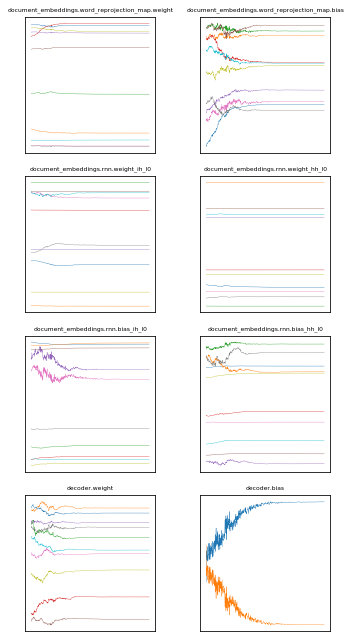

In [7]:
%matplotlib inline

# 8. plot training curves (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('fall-train/loss.tsv')
plotter.plot_weights('fall-train/weights.txt')